In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import gc  # Garbage collector to help manage memory

In [2]:
# Path to the file
file_path = '20250314_085258--2324611--2324910.npy'

# First, check the file size
file_size_gb = os.path.getsize(file_path) / (1024 ** 3)
print(f"File size: {file_size_gb:.2f} GB")

File size: 13.90 GB


In [3]:
# 1. Investigate shape and datatype using numpy.lib.format
# This allows getting metadata without loading the entire array
with open(file_path, 'rb') as f:
    version = np.lib.format.read_magic(f)
    shape, fortran_order, dtype = np.lib.format.read_array_header_1_0(f)
    
print(f"Array shape: {shape}")
print(f"Data type: {dtype}")
print(f"Fortran order: {fortran_order}")

Array shape: (300, 1080, 1920, 3)
Data type: float64
Fortran order: False


In [4]:
# Calculate number of elements and memory usage
num_elements = np.prod(shape)
element_size = np.dtype(dtype).itemsize
total_size_gb = (num_elements * element_size) / (1024**3)

print(f"Number of elements: {num_elements}")
print(f"Element size: {element_size} bytes")
print(f"Calculated size: {total_size_gb:.2f} GB")

Number of elements: 1866240000
Element size: 8 bytes
Calculated size: 13.90 GB


In [8]:
# Function to load a specific frame from the file without loading the entire array
def load_specific_frame(file_path, frame_idx):
    # We'll use np.load with mmap_mode to avoid loading the entire array
    mmap_data = np.load(file_path, mmap_mode='r')
    
    # Extract just the frame we want
    single_frame = mmap_data[frame_idx].copy()  # .copy() to get it out of mmap
    
    # Close the mmap to free resources
    mmap_data._mmap.close()
    del mmap_data
    gc.collect()
    
    return single_frame

In [23]:
# Function to visualize a frame with individual bands
def visualize_frame(frame, title):
    # Check the dimensions to confirm it's a multi-channel frame
    if len(frame.shape) == 3 and frame.shape[2] >= 3:  # Has at least 3 channels
        # Get the number of bands to display (at most 3)
        num_bands = min(3, frame.shape[2])
        band_names = ['Red', 'Green', 'Blue'] if num_bands == 3 else [f'Band {i+1}' for i in range(num_bands)]
        
        # Calculate figure dimensions with 16:9 aspect ratio
        # The height will be smaller than width to match typical 16:9 data
        width = 16
        height = 9
        fig_height = width * (9/16) * 0.7  # 0.7 factor to make it shorter
        
        # Create a figure with subplots for each band
        fig, axes = plt.subplots(1, num_bands, figsize=(width, fig_height))
        fig.suptitle(title, fontsize=16)
        
        # For each band/channel
        for i in range(num_bands):
            band = frame[:, :, i]
            
            # Handle float64 data - normalize if values are outside [0, 1] range
            vmin, vmax = None, None
            if np.issubdtype(band.dtype, np.floating):
                if band.max() > 1.0 or band.min() < 0.0:
                    vmin = np.percentile(band, 1)  # 1st percentile to avoid outliers
                    vmax = np.percentile(band, 99)  # 99th percentile to avoid outliers
            
            # Display the image
            im = axes[i].imshow(band, cmap='viridis', vmin=vmin, vmax=vmax)
            axes[i].set_title(f"{band_names[i]}")
            axes[i].axis('on')
            fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
            
            # Add min/max annotations
            axes[i].text(0.05, 0.95, f"Min: {band.min():.2f}", transform=axes[i].transAxes, 
                        color='white', fontweight='bold', backgroundcolor='black', fontsize=9)
            axes[i].text(0.05, 0.85, f"Max: {band.max():.2f}", transform=axes[i].transAxes, 
                        color='white', fontweight='bold', backgroundcolor='black', fontsize=9)
            axes[i].text(0.05, 0.75, f"Mean: {band.mean():.2f}", transform=axes[i].transAxes, 
                        color='white', fontweight='bold', backgroundcolor='black', fontsize=9)
            
    elif len(frame.shape) == 2 or (len(frame.shape) == 3 and frame.shape[2] == 1):  # Grayscale
        # Calculate figure dimensions with 16:9 aspect ratio
        width = 12
        height = width * (9/16) * 0.6
        
        plt.figure(figsize=(width, height))
        
        # Extract single channel if needed
        if len(frame.shape) == 3:
            frame = frame[:, :, 0]
            
        # Handle float64 data - normalize if values are outside [0, 1] range
        vmin, vmax = None, None
        if np.issubdtype(frame.dtype, np.floating):
            if frame.max() > 1.0 or frame.min() < 0.0:
                vmin = np.percentile(frame, 1)  # 1st percentile to avoid outliers
                vmax = np.percentile(frame, 99)  # 99th percentile to avoid outliers
                
        # Display the image
        im = plt.imshow(frame, cmap='viridis', vmin=vmin, vmax=vmax)
        plt.title(title)
        plt.colorbar(fraction=0.046, pad=0.04)
        
        # Add min/max annotations
        plt.text(0.05, 0.95, f"Min: {frame.min():.2f}", transform=plt.gca().transAxes, 
                color='white', fontweight='bold', backgroundcolor='black', fontsize=9)
        plt.text(0.05, 0.85, f"Max: {frame.max():.2f}", transform=plt.gca().transAxes, 
                color='white', fontweight='bold', backgroundcolor='black', fontsize=9)
        plt.text(0.05, 0.75, f"Mean: {frame.mean():.2f}", transform=plt.gca().transAxes, 
                color='white', fontweight='bold', backgroundcolor='black', fontsize=9)
    else:
        print(f"Unsupported frame shape: {frame.shape}")
        return
    
    plt.tight_layout()
    plt.show()

In [25]:
# 2. Visualize a subset of frames - first frame from each of `num_segments` parts
def visualize_subset_frames(file_path, num_segments=10):
    # Use mmap to get shape without loading entire array
    mmap_data = np.load(file_path, mmap_mode='r')
    total_frames = mmap_data.shape[0]
    frame_shape = mmap_data.shape[1:]
    
    print(f"Dataset info:")
    print(f"- Total frames: {total_frames}")
    print(f"- Frame dimensions: {frame_shape}")
    if len(frame_shape) == 3:
        print(f"- Frame aspect ratio: {frame_shape[1]/frame_shape[0]:.2f}")
        print(f"- Number of channels: {frame_shape[2]}")
    
    # Calculate sampling points across `num_segments` segments
    frame_indices = [int(i * total_frames / num_segments) for i in range(num_segments)]
    print(f"Sampling frames at indices: {frame_indices}")
    
    # Close mmap to free resources before proceeding
    mmap_data._mmap.close()
    del mmap_data
    gc.collect()
    
    # Now load and visualize each sampled frame
    for i, frame_idx in enumerate(frame_indices):
        print(f"\nLoading frame {frame_idx} (segment {i+1}/{num_segments})")
        try:
            frame = load_specific_frame(file_path, frame_idx)
            visualize_frame(frame, f"Frame {frame_idx} (segment {i+1}/{num_segments})")
            
            # Clean up to ensure memory is freed
            del frame
            gc.collect()
            
            # Optional: pause between visualizations to inspect each one
            # if i < len(frame_indices) - 1:
            #     resp = input("Press Enter to continue to next frame (or 'q' to quit): ")
            #     if resp.lower() == 'q':
            #         break
                
        except Exception as e:
            print(f"Error visualizing frame {frame_idx}: {e}")

Dataset info:
- Total frames: 300
- Frame dimensions: (1080, 1920, 3)
- Frame aspect ratio: 1.78
- Number of channels: 3
Sampling frames at indices: [0, 60, 120, 180, 240]

Loading frame 0 (segment 1/5)


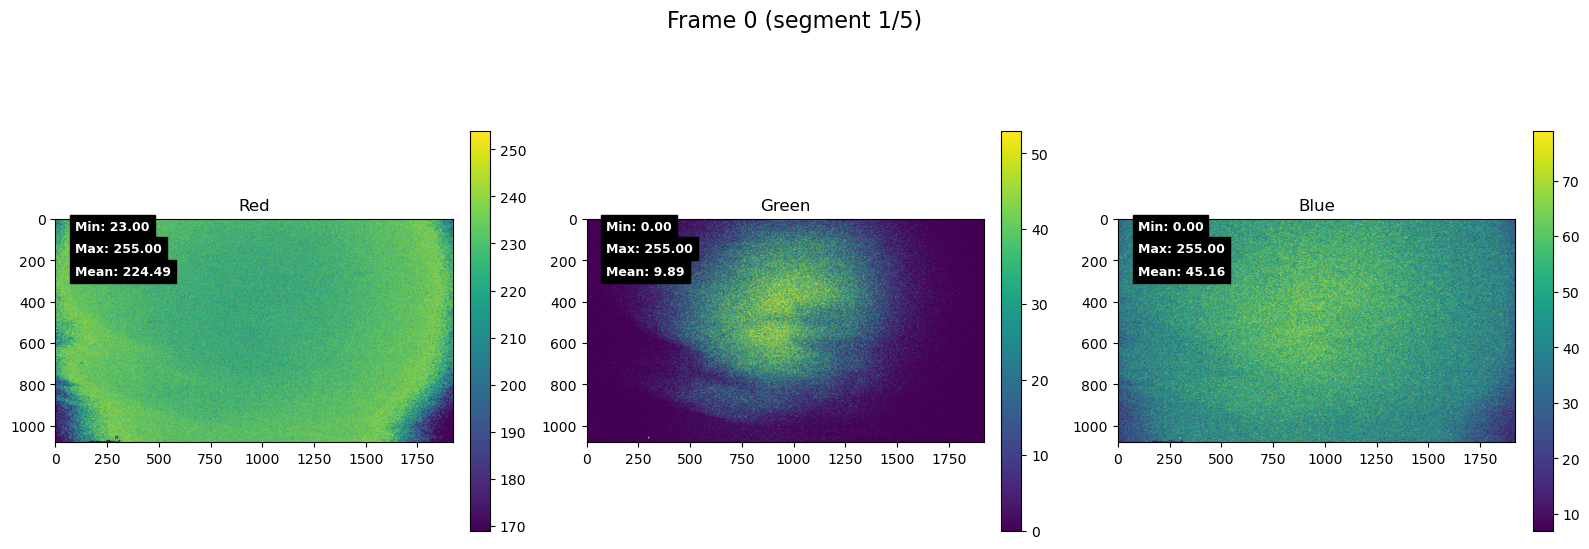


Loading frame 60 (segment 2/5)


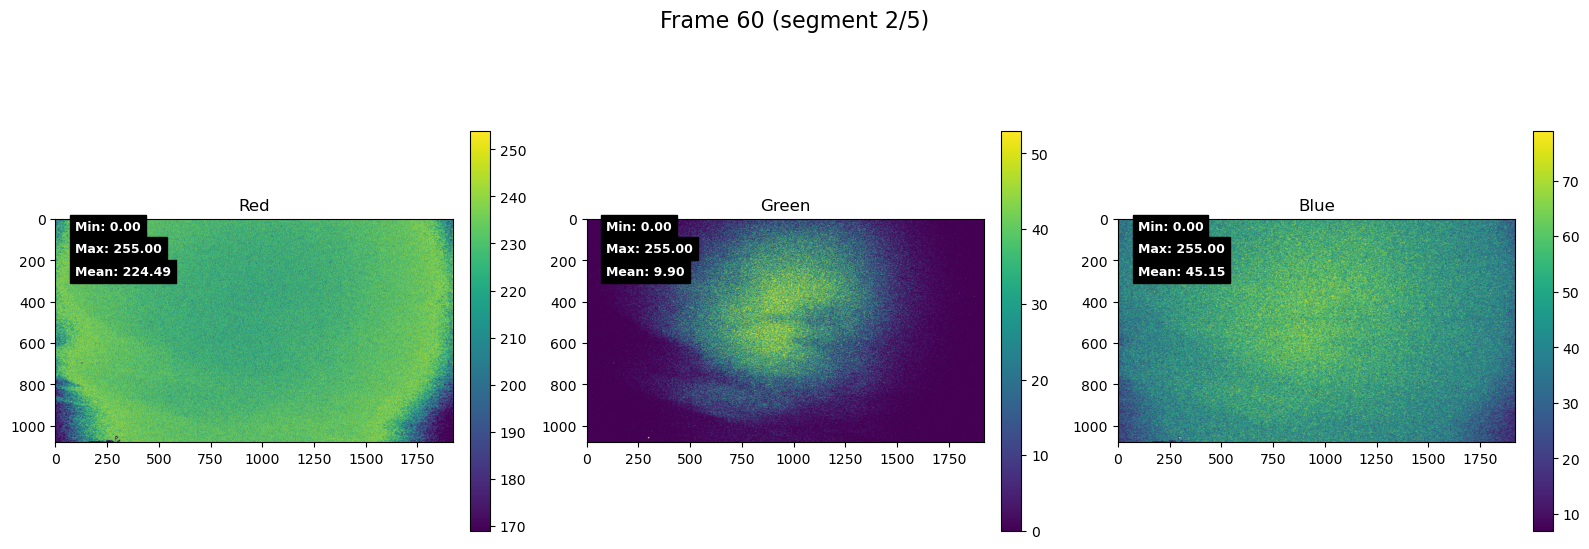


Loading frame 120 (segment 3/5)


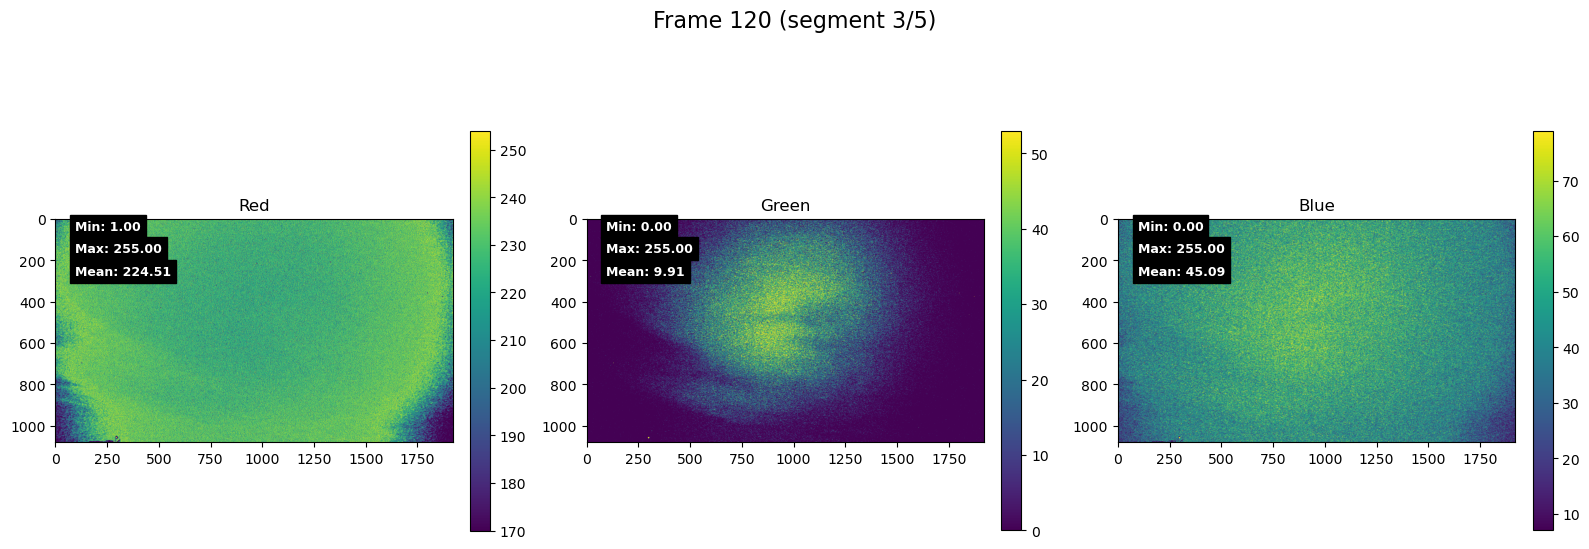


Loading frame 180 (segment 4/5)


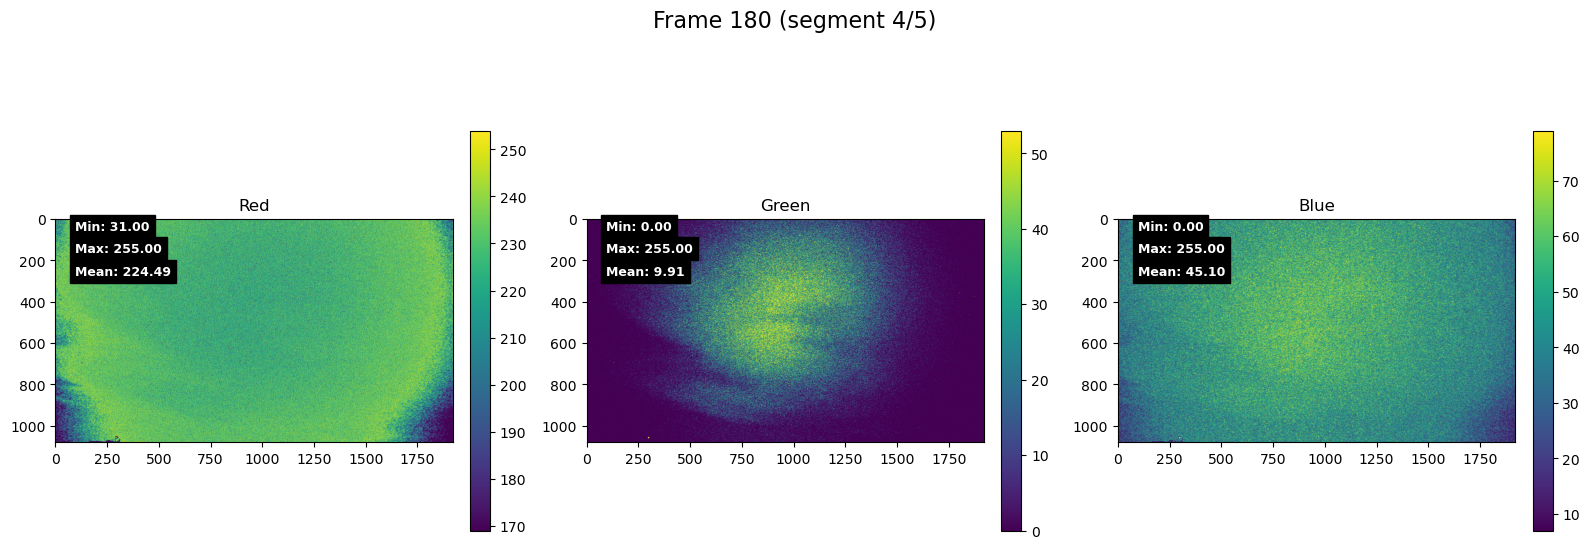


Loading frame 240 (segment 5/5)


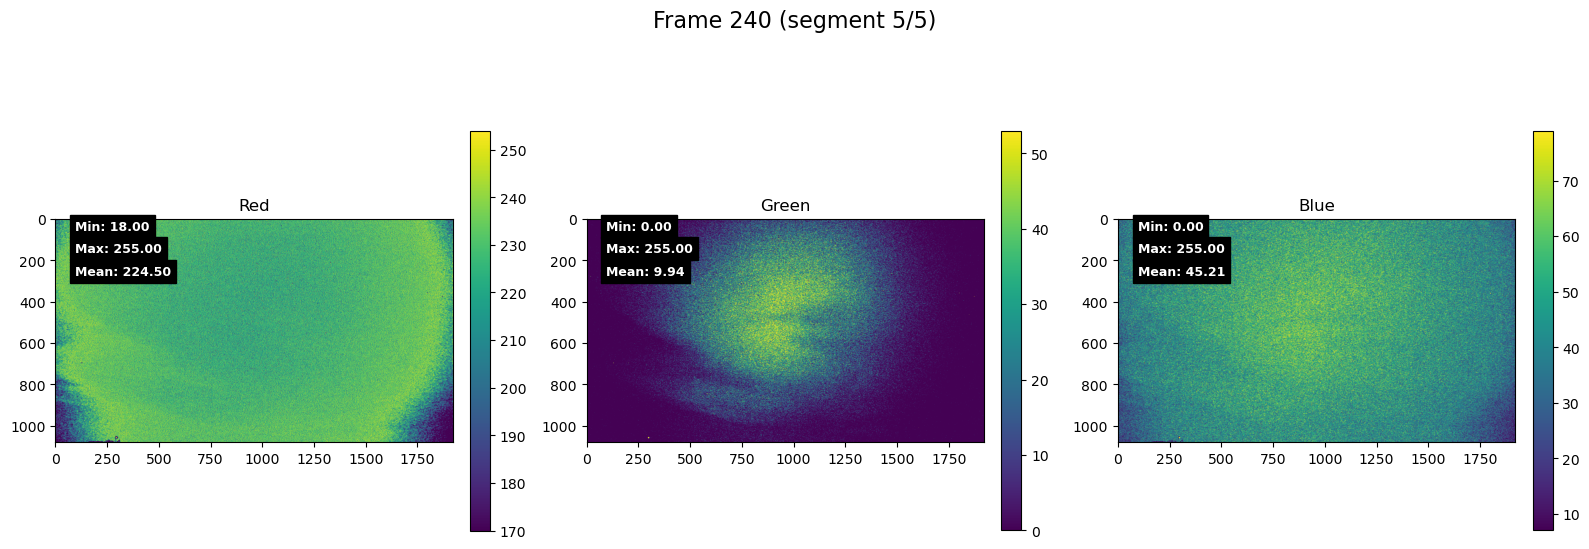

In [26]:
# Run the visualization
visualize_subset_frames(file_path, num_segments=5)